# A4 Feature Engineering [𐄡]

#### Welcome to A4! 

Please enter answers to the questions in the specified Markdown cells below, and complete the code snippets in the associated python files as specified. When you are done with the assignment, follow the instructions at the end of this assignment to submit.

### Learning Objective 🌱
In this assignment, you will gain experience transforming clinical data into sets of features for downstream statistical analysis, utilizing the cohort that you developed in A3. In particular, you will extract features from vitals, diagnosis codes, and more that can be used to predict the future development of septic shock. You will practice using common time-saving tools in the **Pandas 🐼** library and **Python 🐍** programming language that are ideally suited to these tasks.

### Resources 📖
- Pandas Cheat Sheet 🐼: [https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

- Relevant publications:

  - You will not be replicating the models presented in ["A targeted real-time early warning score (TREWScore) for septic shock" by Henry et al.](http://stm.sciencemag.org/content/7/299/299ra122.full) directly, but we include a link to the paper for your reference.



### Environment Set-Up 🐍
To begin, we will need to set up an virtual environment with the necessary packages. A virtual environment is a self-contained directory that contains a Python interpreter (aka Python installation) and any additional packages/modules that are required for a specific project. It allows you to isolate your project's dependencies from other projects that may have different versions or requirements of the same packages.

In this course, we require that you utilize [Miniconda](https://docs.conda.io/en/latest/miniconda.html) to manage your virtual environments. Miniconda is a lightweight version of [Anaconda](https://www.anaconda.com/), a popular Python distribution that comes with many of the packages that are commonly used in data science.

#### Instructions for setting up your environment using Miniconda:
1. If you do not already have Miniconda installed, download and install the latest version for your opperating system from the following link: [https://docs.conda.io/en/latest/miniconda.html#latest-miniconda-installer-links](https://docs.conda.io/en/latest/miniconda.html#latest-miniconda-installer-links)

2. Create a new virtual environment for this assignment by running the following command in your terminal:

   ```bash
   conda env create -f environment.yml
   ```

   This will create a new virtual environment called `biomedin215`

3. Activate your new virtual environment by running the following command in your terminal:

   ```bash
   conda activate biomedin215
   ```

   This will activate the virtual environment you created in the previous step.

4. Finally, ensure that your `ipynb` (this notebook)'s kernel is set to utilize
the `biomedin215` virtual environment you created in the previous steps. Depending on
which IDE you are using to run this notebook, the steps to do this may vary.


In [149]:
# Run this cell: 
# The lines below will instruct jupyter to reload imported modules before 
# executing code cells. This enables you to quickly iterate and test revisions
# to your code without having to restart the kernel and reload all of your 
# modules each time you make a code change in a separate python file.

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
# Run this cell to ensure the environment is setup properly
# If you get an error, please ensure that the environment was activated for this notebook
# Note: You do not need to edit this cell
import pandas as pd
import os
import warnings

print("Imports Successful!")

Imports Successful!


### *Note to Students:* 📚

>Throughout the assignment, we have provided `sanity checks`: small warnings that will alert you when your implementation is different from the solution. Our goal in providing these numbers is to help you find bugs or errors in your code that may otherwise have gone unnoticed. Please note: the sanity checks are just tools we provided to be helpful, and should not be treated as a target to hit. We manually grade each assignment based on the code you submit, and not based on whether you get the exact same numbers as the sanity checks.

Even if you are failing the sanity checks, if your implementation is correct with minor errors, you will still receive the majority of the points (if not all).

In [151]:
# Run this cell to set up sanity checks warnings
# Note: You do not need to change anything in this cell

# Creates a custom warning class for sanity checks
class SanityCheck(Warning):
    pass

# Sets up a cosutom warning formatter
def custom_format_warning(message, category, filename, lineno, line=None):
    if category == SanityCheck:
        # Creates a custom warning with orange text
        return f'\033[38;5;208mSanity Check - Difference Flagged:\n{message}\033[0m\n'
    
    return '{}:{}: {}: {}\n'.format(filename, lineno, category.__name__, message)

# Sets the warning formatter for the entire notebook
warnings.formatwarning = custom_format_warning

### Data Description 📂

We will be utilizing the same subset of the [MIMIC III database](https://mimic.mit.edu/docs/iii/about/) we utilized in A3: the 1,000 subject development cohort you created previously. You will start with a dataset very similar to what you may have generated at the end of the prior assignment.

You will analyze the available data to identify a cohort of patients that underwent septic shock during their admission to the ICU. **All of the data you need for this assignment is available on Canvas.** 

Once you have downloaded and unzipped the data, you should see the following `7` csv files:
- `cohort_labels.csv`

- `ADMISSIONS.csv`

- `DIAGNOSES_ICD.csv`

- `notes_small_cohort_v2.csv`

- `snomed_ct_isaclosure.csv`

- `snomed_ct_str_cui.csv`

- `vitals_small_cohort.csv`

**Specify the location of the folder containing the data in the following cells:**

In [152]:
# Specify the path to the folder containing the data files
data_dir = "/Users/nickallen/Documents/GitHub/BMDS215/A4/data" 

In [153]:
# Run this cell to make sure all of the files are in the specified folder
expected_file_list = ["cohort_labels.csv", "ADMISSIONS.csv", "DIAGNOSES_ICD.csv", "notes_small_cohort_v2.csv", "snomed_ct_isaclosure.csv", "snomed_ct_str_cui.csv","vitals_small_cohort.csv"]

for file in expected_file_list:
    assert os.path.exists(os.path.join(data_dir, file)), "Can't find file {}".format(file)

print("All files successfully found")

All files successfully found


# 1. Labeling as a function of features (`10 pts`) 🟩🟩🟩🟥🟩🟩🟥🟩 

## `1.1`: Engineer features to predict septic shock.

Utilizing our version of the 1,000 subject development cohort you created in the previous assignment, in this assignment, your task is to engineer a set of features that will be used as the inputs to a model that will predict:

```
At 12 hours into an admission, whether septic shock will occur during the remainder of the admission, with at least 3 hours of lead time (the amount of time between when an event is predicted to occur and when it actually occurs).
```

To begin, let's load in our intial dataframes. 
- `cohort_labels.csv`: contains the cohort with the various labels we defined in A3. (This dataset will probably look very similar to the dataset you had at the end of A3.)

- `ADMISSIONS.csv`: an extract of the ADMISSIONS table from MIMIC-III. This contains information about patient admission events to the hospital.

In [154]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to change anything in this cell

# Reads in the tables from the CSV files
cohort_labels = pd.read_csv(os.path.join(data_dir, "cohort_labels.csv"))
admissions = pd.read_csv(os.path.join(data_dir, "ADMISSIONS.csv"))

# Sets the column names to be lowercase
admissions.columns = [x.lower() for x in admissions.columns]

In [155]:
# Run this cell to view what the first few rows of the cohort_labels table look like
# Note: You do not need to change anything in this cell
cohort_labels.head(3)


,subject_id,hadm_id,icustay_id,charttime,sepsis,severe_sepsis,septic_shock
0,3,145834,211552.0,2101-10-20T16:40:00Z,False,False,False
1,3,145834,211552.0,2101-10-20T16:49:00Z,False,False,False
2,3,145834,211552.0,2101-10-20T19:12:00Z,False,False,False


In [156]:
# Run this cell to view what the first few rows of the admissions table look like
admissions.head(3)

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1


In [157]:
# (OPTIONAL TODO:) It is always a good idea to filter out columns that you don't need from DataFrames.
# As always, feel free to add code to your notebooks to do this. This is not required for the assignment.
# You may want to come back to this later when you are more familiar with the data and know which columns you need.



## `1.2`:Preprocess dates and times in admissions, diagnoses, and labels.

First, we need to do some preprocessing. When working with dates in Pandas, it is always a good idea to convert the data to a datetime format. This can help improve performance, memory efficiency, and also allow us to use the many built-in features of Pandas that are only available for datetime objects. Implement the function `preprocess_dates` in the file `src/utils.py` following the instructions in the docstring, to convert specific columns in the input dataframe that contain dates to datetime objects.

In [158]:
# Run this cell after you have completed the necessary code
# Note: you do not need to modify the code in this cell
from src.utils import preprocess_dates

preprocess_dates(admissions, ["admittime", "dischtime"], ["%Y-%m-%d %H:%M:%S"]*2, inplace=True)
preprocess_dates(cohort_labels, ["charttime"], ["%Y-%m-%dT%H:%M:%SZ"],inplace=True)

#==============
# Sanity Checks
if not "datetime" in str(admissions["admittime"].dtype).lower():
    warnings.warn("The admittime column is not a datetime object", SanityCheck)

if not admissions["admittime"].dt.tz is not None:
    warnings.warn("The admittime column is not in UTC", SanityCheck)

## `1.3`: Define labels for septic shock.

Next, we will derive the **labels** and **index times** in a way that aligns with the task description above. Note that we are no longer following the same procedure as the TREWScore paper.

We will use the following definitions:

* We will only assign labels to admissions of at least twelve hours in duration.

* An admission is assigned a negative label if septic shock does not occur at any time during the admission.

* An admission is assigned a positive label if septic shock occurs fifteen hours after admission or later.

* Admissions where the earliest time of septic shock occurs prior to fifteen hours after admission are removed from the study.

* For admissions that have valid labels, we assign an index time at twelve hours into the admission. For prediction, we only use information that occurs before the index time.

* In the case that a patient has multiple admissions for which a valid index time and label may be assigned, we only use the latest one.

We will use the above definitions to derive the binary classification labels for septic shock and the corresponding index times for each patient in the dataframe. Our goal is to end up with a dataframe that contains a row for each patient in `cohort_labels` that passed the inclusion criteria, with the following columns:
- `subject_id`: the unique identifier for each patient
- `hadm_id`: the unique identifier for the admission
- `label`: the binary classification label for septic shock
- `index_time`: the index time for the patient (+12 hours from admission start time)

As mentioned above, we do not want to assign labels to admissions that are less than twelve hours in duration. Implement the function `filter_admissions` in `src/labels.py` following the instructions in the docstring and run the following cell.

In [159]:
# Run this cell after you have completed the necessary code
# Note: you do not need to modify the code in this cell
from src.labels import filter_admissions

filtered_admissions = filter_admissions(admissions)

#==============
# Sanity Checks

# Check that the number of rows is correct
if filtered_admissions.shape[0] != 57925:
    warnings.warn("Number of rows is different than expected", SanityCheck)

## `1.4`: Derive index times from admissions.

Our next step will be to merge the two dataframes together, and create two additional columns:
- `relative_charttime`: The amount of time between the charttime and the start of the admission
- `index_time`: The time at which a prediction will be made (12 hours after the start of the admission)

Implement the functions `merge_and_create_times`, `get_relative_charttime`, and `get_index_time` in `src/labels.py` following the instructions in the appropriate docstrings. When you are done, run the cell below to sanity check your implementation.

In [160]:
# Run this cell after you have completed the necessary code
# Note: you do not need to modify the code in this cell
from src.labels import merge_and_create_times

merged_cohort = merge_and_create_times(cohort_labels,filtered_admissions)

#==============
# Sanity Checks
if merged_cohort.shape[0] != 247610:
    warnings.warn(f"Number of rows is different than expected: shape[0] = {merged_cohort.shape[0]}", SanityCheck)

## `1.5`: Create shock labels for patients.

Now we need to use this merged dataframe to create a new dataframe that contains the labels utilizing the definitions above. Implement the function `get_shock_labels` in `A4/labels.py` following the instructions in the docstring to create a new dataframe with a binary septic shock label for each patient.

In [161]:
# Run this cell after you have completed the necessary code
# Note: you do not need to modify the code in this cell
from src.labels import get_shock_labels

shock_labels = get_shock_labels(merged_cohort)


#==============
# Sanity Check:
for col in shock_labels.columns:
    if col not in ["subject_id", "hadm_id", "admittime", "dischtime", "index_time", "label", "icustay_id"]:
        warnings.warn(f"Expected column {col} not found", SanityCheck)
    
if len(shock_labels) != 974:
    warnings.warn(f"Expected length different: length = {len(shock_labels)}", SanityCheck)

if len(shock_labels) != shock_labels["subject_id"].nunique():
    warnings.warn(f"Expected no duplicate rows", SanityCheck)

Sanity Check - Difference Flagged:
Expected length different: length = 977


In [162]:
# Run this cell to see the class balance of the labels:
# Note: you do not need to modify the code in this cell
shock_labels["label"].value_counts()

label
False    911
True      66
Name: count, dtype: int64

# 2 Feature engineering [𐄡] (`23 pts`)

Now that we have derived labels and index times for each patient in our cohort, we can start to engineer some features from the data that occur prior to the index times and will be useful for predicting onset of septic shock.

First lets deal with diagnoses. Load in the `DIAGNOSES_ICD.csv` file by running the cell below.

In [163]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to modify the code in this cell

# Reads in the table from the CSV file
diagnoses = pd.read_csv(os.path.join(data_dir, "DIAGNOSES_ICD.csv"))
# Sets diagnoses's column names to lower case
diagnoses.columns = [x.lower() for x in diagnoses.columns]

## `2.1`: (`2 pts`) Identify which column/table in MIMIC to use for diagnosis time and justify.

Review the documentation for MIMIC to answer the following question.

**Which column from which table in MIMIC should you use to find the time of each diagnosis? Justify your response.**

To find the time of each diagnosis we should join the DIAGNOSIS_ICD table with the ADMISSIONS table but using hadm_id. From here, we cna use ADMITTIME column to determine the time of the diagnosis.

## `2.2`: (`3 pts`) Link admissions, diagnoses, and labels, then count subjects with diagnoses before index_time.

Utilizing the column you selected in the previous question, implement the function `get_diagnoses` in `A4/features.py` following the instructions in the docstring. When you have completed your implementation, run the cell below to sanity check.

In [164]:
from src.features import get_diagnoses

dx_features = get_diagnoses(admissions, diagnoses, shock_labels)

#============
# Sanity Check
if dx_features.shape[0] != 4031:
    warnings.warn(f"Expected length different: shape[0] = {dx_features.shape[0]}", SanityCheck)

**How many subjects have diagnoses recorded prior to the index_time? Does the resulting number make sense?**


In [165]:
dx_features["subject_id"].nunique()

210

You have 974 labeled subjects. DIAGNOSES_ICD is visit-level and timestamp-free, so we proxy “diagnosis time” with ADMISSIONS.admittime. By filtering to diagnosis_time < index_time and excluding the index admission, you’re effectively counting only diagnoses from prior admissions.210 unique subjects (~22% of 974) having pre-index diagnoses is therefore reasonable: it reflects patients with at least one earlier MIMIC-recorded admission; others either have no prior admissions or their history falls outside MIMIC.

## `2.3`: (`4 pts`) Find top 10 most common ICD9 codes by patient count, lookup top 3 online, report definitions.

Implement code in the following cell to answer the question

**What are the top 10 most common diagnosis codes (by number of unique patients who had the code in their history) in the data frame resulting from question 2.2? Look up the top 3 codes online and report what they refer to.**

In [166]:
# Top 10 ICD9 codes by unique patient count
top_10 = (
    dx_features.groupby("icd9_code")["subject_id"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={"subject_id": "unique_patient_count"})
)
print("Top 10 Most Common Diagnosis Codes (patient count):")
print(top_10.to_string(index=False))

# List the top 3 codes to look up definitions
top_3_codes = top_10["icd9_code"].head(3).tolist()
print("\nTop 3 codes:", top_3_codes)

Top 10 Most Common Diagnosis Codes (patient count):
icd9_code  unique_patient_count
     4019                    93
     4280                    77
    41401                    73
     5849                    63
    42731                    60
     2859                    43
     5990                    41
    25000                    38
    51881                    38
      486                    35

Top 3 codes: ['4019', '4280', '41401']


- 401.9 — Unspecified essential hypertension (primary hypertension; benign/malignant not stated).
- 428.0 — Congestive heart failure, unspecified.
- 414.01 — Coronary atherosclerosis of native coronary artery.

## `2.4`: (`4 pts`) Implement and interpret resulting histogram.

In this step we will create a histogram for the set of codes and patients that remain after the index time filtering step. 

Implement the function `show_diagnosis_hist` in `visualize.py` following the instructions in the docstring. When you are done, run the cell below to show the histogram.

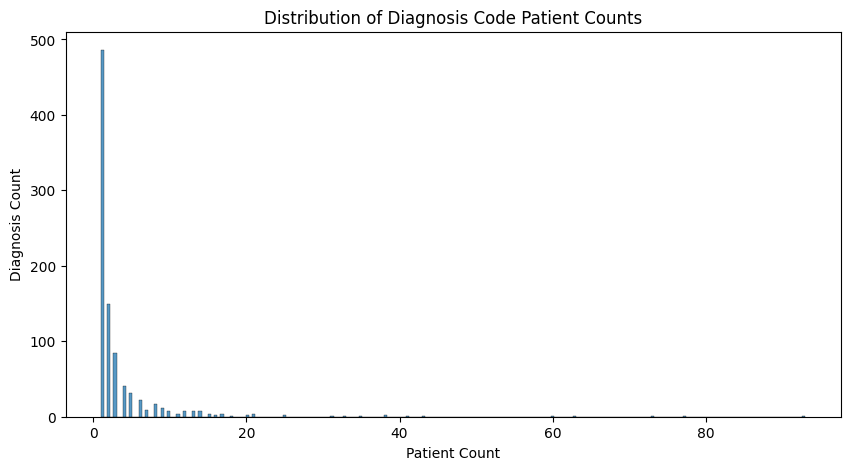

In [167]:
from src.visualize import show_diagnosis_hist

# Create the plot
show_diagnosis_hist(dx_features, "diagnosis_count_hist.png")

**In 1-2 sentences, interpret the resulting histogram.**

The distribution is extremely right‑skewed. This shows us most ICD9 codes occur in only a handful of patient histories (often just 1–3), with a long tail of a few codes appearing in many patients.

## `2.5`: (`5 pts`) Compute Information Content (IC) for each diagnosis code.

From the histogram you generated earlier, it's evident that there's a substantial variation in the frequency of different diagnoses. Specifically, a significant number of diagnoses appear very infrequently in the dataset.

Such a distribution is characteristic of a `sparse feature space`. Here is what that means:

`Sparse Feature Space`: In the context of data with categorical variables, a sparse feature space refers to the scenario where many possible features (in this case, diagnosis codes) appear infrequently, resulting in a 'wide form' matrix with many zeros or absent values.

This can have problematic implications for downstream analyses:
- First, sparse features can pose **computational challenges**: Many machine learning algorithms struggle with high dimensionality and sparsity. They can become computationally intensive or may not work optimally.
- Second, sparse features can lead to **issues with generalization**: Rare features often don't contribute significantly to model training. In some cases, they might even introduce noise, making the model overfit to a training set and perform poorly on new, unseen data.





Given these challenges, it's beneficial to address sparsity. One strategy to manage this involves quantifying the "usefulness" or "specificity" of each feature, and utilizing this information to select features or even perform feature aggregation (grouping features to capture broader patterns). This is where `Information Content (IC)` comes into play:

**Definition**: `IC` is a metric that provides a measure of the specificity or the informativeness of a feature based on its frequency of occurrence. Features that are very common have a higher probability and thus a lower IC, while rare features have a lower probability, resulting in a high IC value.

The IC of a feature that occurs in a set of records is calculated as follows:

$IC\left(\text{featureA}\right) = -log_2 \left( \frac{count(\text{Patients with featureA})}{count(\text{All Patients})} \right)$

Implement the function `calc_ic` in `src/features.py` to calculate the IC of each diagnosis code in the dx_features dataframe using the equation above and following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [168]:
from src.features import calc_ic

icd9_ic = calc_ic(dx_features, all_patients_count=len(shock_labels))

if icd9_ic.shape[0] != 914:
    warnings.warn(f"Expected number of rows different: shape[0] = {icd9_ic.shape[0]}", SanityCheck)

## `2.6` (`3 pts`) Report IC range (min, max) and top 10 most specific ICD9 codes.

Use the code cell below to answer the following question:

**What is the range (min and max) of ICs observed in your data? What are the 10 most specific ICD9 codes?**



In [169]:
# IC range (min, max) and top 10 most specific ICD9 codes (highest IC)
ic_min = icd9_ic["IC"].min()
ic_max = icd9_ic["IC"].max()
print(f"IC range: min={ic_min:.3f}, max={ic_max:.3f}")

top10_specific = icd9_ic.sort_values("IC", ascending=False).head(10).reset_index(drop=True)
print("\nTop 10 most specific ICD9 codes (highest IC):")
print(top10_specific.to_string(index=False))

IC range: min=3.393, max=9.932

Top 10 most specific ICD9 codes (highest IC):
icd9_code       IC
     5531 9.932215
     5932 9.932215
    59381 9.932215
    59582 9.932215
     5960 9.932215
     5991 9.932215
     6000 9.932215
    60091 9.932215
    61172 9.932215
     6191 9.932215


## `2.7` (`2 pts`) Filter to keep diagnoses with IC between 4 and 9.

Now it's time to perform some feature selection. Implement the function `filter_ic` in `src/features.py` to filter the dataframe to only include the diagnoses with an IC between 4 and 9 (inclusive) following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [170]:
from src.features import filter_ic

dx_selected = filter_ic(dx_features, icd9_ic)


#============
# Sanity Check
if dx_selected.shape[0] != 3044:
    warnings.warn(f"Expected number of rows different: shape[0] = {dx_selected.shape[0]}", SanityCheck)

## `3` (`24 pts`) Time Binning

## `3.1` (`12 pts`) Create patient-feature matrix with time-binned diagnosis counts (≤6 months, >6 months).

Now we have our diagnosis features and the times they occurred for each patient. The next step is to create a patient-feature matrix that summarizes and organizes these diagnosis features. In this matrix, each row should represent a patient and each column should represent a diagnosis code, time-binned by whether or not it occurred in the 6 months prior to the index time.

Put simply, for each diagnosis code, we want to generate two features:

- One feature representing the count of the number of times the code was observed in the six months prior to the index time.
- Another feature for the number of times that code appeared more than six months before the index time.

Note that the ICU stay is the first time many patients have been seen at this hospital, so patients may have few or no prior recorded diagnoses.


Implement the function `get_diagnoses_features` in `src/features.py` to create the patient-feature matrix following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [171]:
from src.features import get_diagnosis_features

diagnosis_features = get_diagnosis_features(dx_selected)

#============
# Sanity Check

if diagnosis_features.shape[0] != 209:
    warnings.warn(f"Expected number of rows different: shape[0] = {diagnosis_features.shape[0]}", SanityCheck)

## `3.2` (`4 pts`) Filter notes to before index time day.

Now let's add features from notes. To do so, we'll have to process some text.

The `noteevents` table in MIMIC is large and unwieldy, so we've extracted the rows from that table that you will need. The result is in the file `notes_small_cohort_v2.csv`. Let's load this in now.

In [172]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to modify the code in this cell

# Reads in the table from the CSV file
notes = pd.read_csv(os.path.join(data_dir, "notes_small_cohort_v2.csv"))

# Set notes' column names to lower case
notes.columns = [x.lower() for x in notes.columns]

# Utilizes the preprocess_dates function to convert the dates to datetime objects
preprocess_dates(notes, ["chartdate"], ["%Y-%m-%d"], inplace=True)


In [173]:
# Let's check out what the notes data looks like
notes.head(3)

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,note_text
0,44005,3,145834,2101-10-31 00:00:00+00:00,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2101-10-20**] Discharg...
1,94503,3,145834,2101-10-21 00:00:00+00:00,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: S/P Car...
2,94502,3,145834,2101-10-21 00:00:00+00:00,NaN,NaN,Echo,Report,NaN,NaN,PATIENT/TEST INFORMATION:\nIndication: Left ve...


In the MIMIC database, notes are primarily timestamped using the chartdate column, which captures the date (but not the precise time) when the note was recorded. Another column, charttime, exists, but it is predominantly empty or null for most entries. This presents a challenge when we wish to filter notes based on precise times, such as a patient-specific cutoff time.

To address this, our approach will be to filter notes by ensuring that they were recorded strictly before the day corresponding to each patient's `index_time`. This means that if a note's chartdate is the same as the `index_time` (*even if charttime were available*), we would exclude it because we can't ascertain if it was before or after the exact `index_time` time on that day.

Implement the function `filter_by_chartdate` in `src/notes.py` to filter the notes dataframe to only include notes in a patient's record that were recorded before the day corresponding to each patient's `index_time`, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [174]:
from src.notes import filter_by_chartdate

notes_filtered = filter_by_chartdate(shock_labels, notes)

#============
# Sanity Check
if notes_filtered.shape[0] != 13213:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {notes_filtered.shape[0]}", SanityCheck)

Sanity Check - Difference Flagged:
Number of rows differs from expected: shape[0] = 13224


## `3.3` (`2 pts`) Combine SNOMED CT hierarchy and terms.

The Unified Medical Language System (UMLS) is a multi-dimensional and dynamic compendium developed by the U.S. National Library of Medicine (NLM) to bridge the gap between various healthcare terminologies and classification systems. At the heart of UMLS lie various terminologies, which provide concept hierarchies as well as sets of terms for individual concepts. For example, there are more than 50 terms in UMLS terminologies for the concept `myocardial infarction`!

Here we will use the SNOMED CT (Systematized Nomenclature of Medicine - Clinical Terms): A comprehensive clinical terminology encompassing diseases, clinical findings, procedures, etc. SNOMED CT is a multi-hierarchy system, meaning that each concept can have multiple parents. For example, the concept `myocardial infarction` has two parents: `acute coronary syndrome` and `myocardial disorder`.

In this assignment, you will use the SNOMED CT hierarchy and UMLS term sets to construct a dictionary of terms for inflammatory disorders, which you will use to search for associated terms in MIMIC III notes to create additional features.

First, load `snomed_ct_isaclosure.csv` and `snomed_ct_str_cui.csv` by running the code in the following cell:

In [175]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to modify the code in this cell

# Reads in tables from the CSV files
snomed_ct_isaclosure = pd.read_csv(os.path.join(data_dir, "snomed_ct_isaclosure.csv"))
snomed_ct_str_cui = pd.read_csv(os.path.join(data_dir, "snomed_ct_str_cui.csv"))

In [176]:
# snomed_ct_isaclosure contains the child-parent CUI relationships for all of SNOMED CT.
# Note: You do not need to modify the code in this cell
snomed_ct_isaclosure.head(3)

,descendant,ancestor,dist
0,C0038891,C0038891,0
1,C0038891,C0220806,3
2,C0038891,C0033684,2


In [177]:
# snomed_ct_str_cui contains the terms (each with a unique term identifier, tid) for each SNOMED CT CUI
# Note: You do not need to modify the code in this cell
snomed_ct_str_cui.head(3)

,tid,str,CUI
0,1,and,C1706368
1,2,0,C0919414
2,3,of,C0332285


Implement the function `merge_snomed` in `src/notes.py` to merge the two dataframes together, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [178]:
from src.notes import merge_snomed

# Merge the two tables
snomed_ct_concept_str = merge_snomed(snomed_ct_isaclosure, snomed_ct_str_cui)

#============
# Sanity Check
if snomed_ct_concept_str.shape[0] != 16407662:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {snomed_ct_concept_str.shape[0]}", SanityCheck)

if snomed_ct_concept_str.shape[1] != 2:
    warnings.warn(f"Number of columns differs from expected: shape[1] = {snomed_ct_concept_str.shape[1]}", SanityCheck)

## `3.4` (`6 pts`) Create list for inflammatory disorders (≤20 chars)

One feature that is very likely to impact the likelihood of a patient to develop septic shock is whether they currently have or have a history of inflammatory disorders. Let's extract information from clinical notes to look for the presence of this class of disease.

To accomplish this,  implement the function `get_cui_list` in `src/notes.py` to get a list of all the terms that correspond to a CUI in the `snomed_ct_isaclosure` dataframe and that have a specified number of characters or fewer, following the instructions in the docstring. Then, use this function to get a set of terms for `inflammatory disorders` (`C1290884`) that have 20 characters or fewer. How many terms are in the dictionary?

In [179]:
from src.notes import get_cui_list

inflammatory_disorder_list = get_cui_list(snomed_ct_concept_str, "C1290884", 20)

#============
# Sanity Check

if len(inflammatory_disorder_list) != 2991:
    warnings.warn(f"Length of inflammatory_disorder_list differs from expected: length = {len(inflammatory_disorder_list)}", SanityCheck)

if "ekc" != inflammatory_disorder_list[0]:
    warnings.warn(f"First element of inflammatory_disorder_list differs from expected: element = {inflammatory_disorder_list[0]}", SanityCheck)

## `4` (`43 pts`) Get features from notes

## `4.1` (`7 pts`) Find inflammatory disorder terms in notes.

Now let's determine if the notes contain these terms. Implement the function `extract_terms` in `src/notes.py` to search the note text for the terms you collected in the previous step, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [180]:
from src.notes import extract_terms

term_df = extract_terms(notes_filtered, inflammatory_disorder_list, 50)

#============
# Sanity Check
if term_df.shape[0] != 13213:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {term_df.shape[0]}", SanityCheck)


Sanity Check - Difference Flagged:
Number of rows differs from expected: shape[0] = 13224


## `4.2` (`6 pts`) Reshape terms and map back to concepts.

Now that we have extracted the terms from the notes and have a representation of which term is in which note in a `wide` dataframe format, we want to determine which concepts are present in each note. To do this, we will reshape the dataframe to a `long` format and normalize terms back to their corresponding concepts. 

Implement the function `normalize_terms` in `src/notes.py` following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [181]:
from src.notes import normalize_terms

concept_df = normalize_terms(term_df, snomed_ct_concept_str)

## `4.3` (`7 pts`) Build patient-feature matrix from notes (binary indicators).

As with the diagnoses, we must transform these concepts data into a patient-feature matrix. Transform `concept_df` into a patient-feature matrix where each row is a patient and each column is the presence or absence of a concept. Here we are not going to do any time binning. Each concept should have only one column. Instead of counts, use a binary indicator to indicate that the concept was present in the patient's notes.

Implement the function `get_note_concept_features` in `src/notes.py` following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [182]:
from src.notes import get_note_concept_features

note_concept_features = get_note_concept_features(concept_df)

## `4.4` (`2 pts`) Filter vitals (HeartRate) before index time.

Now let's engineer some features from vital sign measurements also relevant to predicting septic shock! Load in the `vitals_small_cohort.csv` file by running the cell below.

In [183]:
# Run this cell to load the data from the CSV files into Pandas DataFrames
# Note: You do not need to modify the code in this cell

# Reads in the table from the CSV file
vitals = pd.read_csv(os.path.join(data_dir, "vitals_small_cohort.csv"))

# Preprocess the dates
preprocess_dates(vitals, ["charttime"], ["%Y-%m-%dT%H:%M:%SZ"], inplace=True)


Let's filter the vitals so we are only looking at Heart Rate measurements that were taken prior to the patient's index time.

Implement the function `filter_vitals` in `src/vitals.py` to filter the vitals dataframe to only include measurements that were taken prior to the patient's index time, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [184]:
from src.vitals import filter_vitals

vitals_filtered_hr = filter_vitals(vitals, shock_labels, ["HeartRate"])

# ============
# Sanity Check
if vitals_filtered_hr.shape[0] != 9328:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {vitals_filtered_hr.shape[0]}", SanityCheck)

## `4.5` (`4 pts`) Plot latest heart rate histogram.

Now lets construct some features. One feature of interest might be the latest value of the heart rate before the `index_time`. 

Implement the function `get_latest_hr` in `src/vitals.py` to get the latest heart rate measurement before the `index_time` for each patient. When you are done, run the cell below to sanity check your implementation.

In [185]:
from src.vitals import get_latest_hr

latest_hr_df = get_latest_hr(vitals_filtered_hr)

Now, let's create a histogram to look at the distribution of the latest heart rate values.

Implement the function `show_hr_hist` in `src/visualize.py` to plot a histogram of the latest heart rate values, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


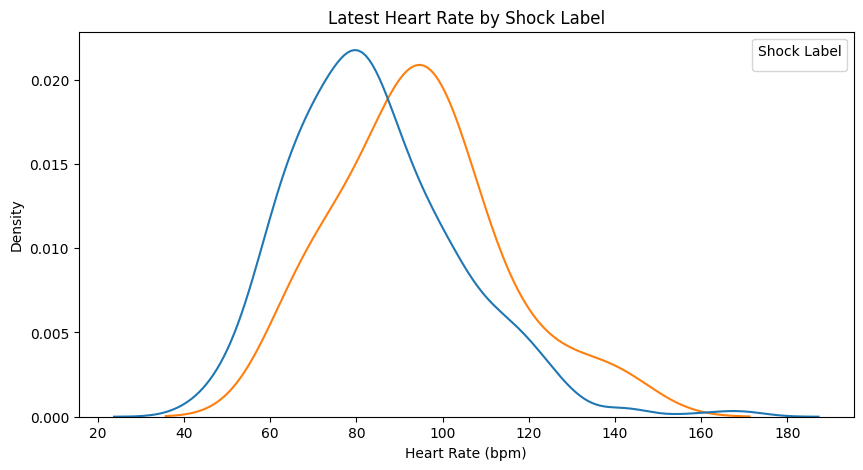

In [186]:
from src.visualize import show_hr_plot

# Create the plot
show_hr_plot(latest_hr_df, "hr_plot.png")

## `4.6` (`4 pts`) Plot time difference between latest HR and index time

There are some additional considerations we should think about prior to utilizing the latest heart rate feature in our model. For example, if the latest recorded heart rate is not very close to the patient's `index_time`, the feature may not be very useful for that patient. 

To examine this issue, let's plot the distribution of the time between the latest heart rate measurement and the `index_time`. Implement the function `show_hr_time_hist` in `src/visualize.py` to plot a histogram of the time between the latest heart rate measurement and the `index_time`, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


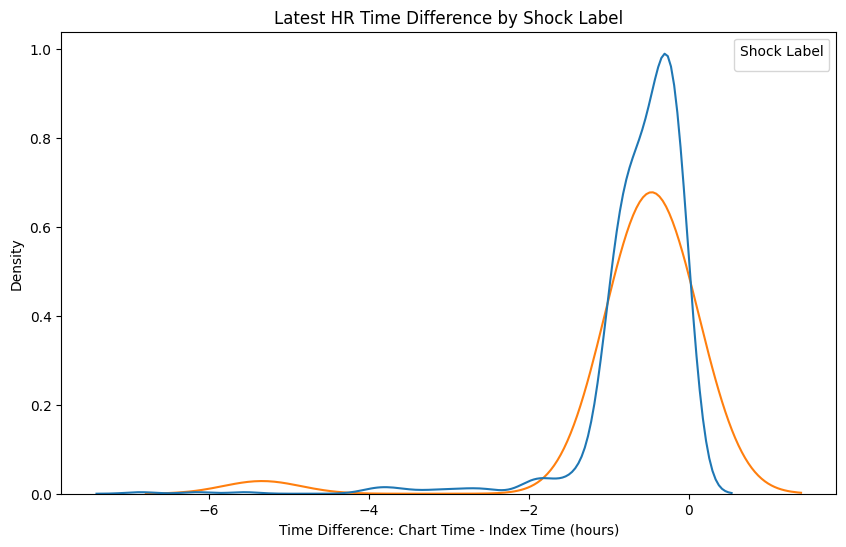

In [187]:
from src.visualize import show_hr_time_plot

# Create the plot
show_hr_time_plot(latest_hr_df, "hr_plot.png")

## `4.7` (`5 pts`) Compute time-weighted average heart rate.

Another concern is that when monitoring patients, especially when thinking about heart rate recordings, relying on a single data point can be misleading. By merely using the last recorded value, we run the risk of using an atypical value. Imagine a scenario where a patient's heart rate is regularly around 80 beats per minute, but due to some temporary distress or a device error, the last recorded value spikes to 120 bpm. If we base our analysis or decisions on this single data point, our conclusions will be skewed.

To address these concerns, instead of using just the last measurement, we can utilize a more robust metric: the time-weighted average heart rate. The idea behind a time-weighted average is to account for all measurements while giving more weight to recent ones. This ensures that:
- All data points contribute to the final value.
- More recent data has a higher influence on the average, as it might be more relevant to the patient's current state.

Use the formula $w = e^{(-|\Delta t| - 1)}$ to calculate the weights of each measurement, where $\Delta t$ is the time difference between the measurement time and the cutoff time in hours. 

Calculate the weighted average for each patient with the formula $\bar{x}_w = \sum(x_i w_i)/\sum(w_i)$, where $x_i$ is the value of the measurement and $w_i$ is the weight of that measurement, and $i$ ranges from 1 to the total number of measurements for that patient.

The result should be a dataframe with two columns: `subject_id` and `time_wt_avg`. Implement the function `get_time_weighted_hr` in `src/vitals.py` to calculate the time-weighted average heart rate for each patient, following the instructions in the docstring. When you are done, run the cell below to sanity check your implementation.

In [188]:
from src.vitals import get_time_weighted_hr

time_weighted_hr_df = get_time_weighted_hr(vitals_filtered_hr)

## `4.8` (`4 pts`) Compare latest HR vs time-weighted HR.

Let's do a sanity check to see if what we've done makes sense. We expect that the time-weighted average heart rate and the latest recorded heart rate should be similar.

Make a scatterplot of the latest recorded heart rate (x-axis) and the time-weighted average heart rate (y-axis) of each patient. Implement the function `show_hr_scatter` in `src/visualize.py` to plot the scatterplot. When you are done, run the cell below to sanity check your implementation.

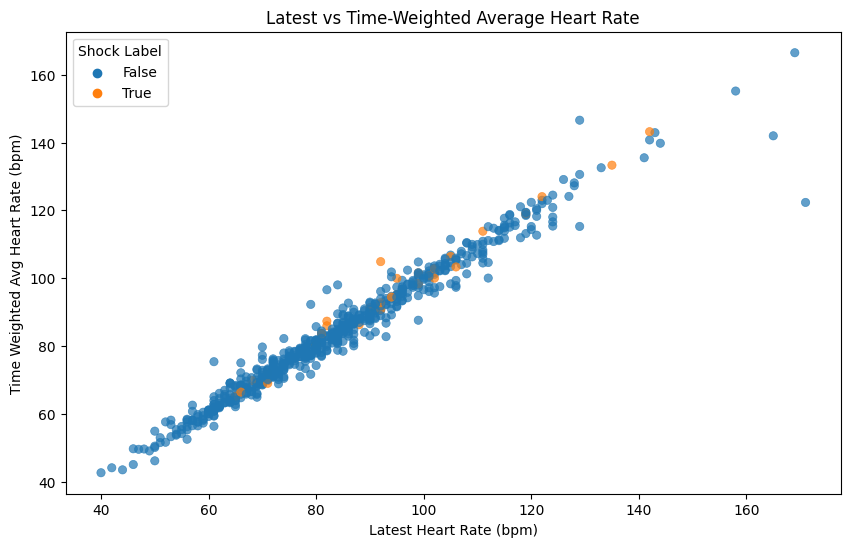

In [189]:
from src.visualize import show_hr_scatter

# Create the plot
show_hr_scatter(latest_hr_df, time_weighted_hr_df, "hr_scatter.png")

In [190]:
# Finally run this cell to get all the heart rate features together in the same dataframe
heart_rate_features = pd.merge(
        latest_hr_df.drop(columns=["charttime"]),
        time_weighted_hr_df,
        on="subject_id",
        how="inner",
    ).drop(columns=["label", "index_time"])

## `4.9` (`4 pts`) Merge diagnosis, notes, and HR features; handle missing values; report feature count.

We're almost there! Our final patient-feature matrix will simply be the amalgamation of the different feature matrices we've created. Implement `join_and_clean_data` in `src/utils.py` to combine the columns of the feature matrices from diagnoses, notes, and heart rate measurements, following the instructions in the docstring. Note that not all patients have diagnoses or note features, so this function should fill in any NA values with 0 to indicate that there were no diagnoses or notes counted. Similarily, not all subjects have heart rate measurements.  Fill NA values for these features with a simple column mean imputation. 

In [191]:
from src.utils import join_and_clean_data

joined = join_and_clean_data(diagnosis_features, note_concept_features, heart_rate_features)

#============
# Sanity Check

if joined.shape[0] != 773:
    warnings.warn(f"Number of rows differs from expected: shape[0] = {joined.shape[0]}", SanityCheck)

if joined.isna().sum().sum() != 0:
    warnings.warn(f"Dataframe contains NaN values, which is not expected", SanityCheck)
  

Sanity Check - Difference Flagged:
Number of rows differs from expected: shape[0] = 775


Use `list(joined.columns)` to look at all the features and make sure everything makes sense.

**How many total features are there?**

In [192]:
print("Total number of features: ", len(joined.columns))
# list(joined.columns)

Total number of features:  1060


All the givens features make sense in the larger context of the notebook.

# `5` Make new features (`20 pts`)

Having made it this far, you have picked up a few generalizable techniques that can now be used to extract features from various modalities of clinical data. To test the skills you've learned thus far, you now have free rein to get creative and derive whatever additional features you would like and use them alongside the disease, text and vitals features as input to a simple classifier. To help you with your task, we provide you with CSV files for ALL of the tables in MIMIC III where each table has been filtered to contain only the records for the patients in our small cohort. These are stored in the folder `additional_data`. 



In [193]:
# Run this cell to see what data files are available
# Note: You do not need to modify the code in this cell

# Let's take a look at what files we have available
# Note: You do not need to modify the code in this cell
file_list = os.listdir(os.path.join(data_dir, "additional_data"))
file_list.sort()

print("Available files: ---")
for ind, f in enumerate(file_list):
    print(f, end=" "*10)
    if ind % 3 == 2:
        print()

Available files: ---
admissions_additional.csv          chartevents_10_additional.csv          chartevents_11_additional.csv          
chartevents_12_additional.csv          chartevents_13_additional.csv          chartevents_14_additional.csv          
chartevents_1_additional.csv          chartevents_2_additional.csv          chartevents_3_additional.csv          
chartevents_4_additional.csv          chartevents_5_additional.csv          chartevents_6_additional.csv          
chartevents_7_additional.csv          chartevents_8_additional.csv          cptevents_additional.csv          
d_cpt_additional.csv          d_icd_diagnoses_additional.csv          d_icd_procedures_additional.csv          
d_items_additional.csv          d_labitems_additional.csv          datetimeevents_additional.csv          
diagnoses_icd_additional.csv          drgcodes_additional.csv          icustays_additional.csv          
inputevents_cv_additional.csv          inputevents_mv_additional.csv          labe

We also provide you with some baseline code below that runs a logistic regression classifier with a Lasso L1 penalty and reports a cross-validation AUC-ROC. Use the code below to see the performance of the model with the features you have already engineered.

In [194]:
# Run this cell (Depending on your computer and your implementation, this cell may take a while to run)
# Note: fit_model is a provided function, you do not need to implement it
# Note: Your implementation is not expected to hit any performance targets.
# With only the features we have defined above, note the results are not be very good.
# In future assignments we will take a closer look at models!
from src.model import fit_model
fit_model(joined, shock_labels)

 20%|██        | 1/5 [00:17<01:08, 17.01s/fold]

Fold 1 ROC AUC Score: 0.6269


 40%|████      | 2/5 [00:40<01:02, 20.89s/fold]

Fold 1 ROC AUC Score: 0.5993


 60%|██████    | 3/5 [01:16<00:55, 27.56s/fold]

Fold 1 ROC AUC Score: 0.5011


 80%|████████  | 4/5 [01:46<00:28, 28.55s/fold]

Fold 1 ROC AUC Score: 0.5816


100%|██████████| 5/5 [02:06<00:00, 25.34s/fold]

Fold 1 ROC AUC Score: 0.6481
Mean ROC AUC Score: 0.5914013777011435


In [195]:
shock_labels.head(2)

,subject_id,hadm_id,icustay_id,admittime,dischtime,index_time,label
0,4,185777,294638.0,2191-03-16 00:28:00+00:00,2191-03-23 18:41:00+00:00,2191-03-16 12:28:00+00:00,False
1,6,107064,228232.0,2175-05-30 07:15:00+00:00,2175-06-15 16:00:00+00:00,2175-05-30 19:15:00+00:00,False



Use the code to do the following:
* Outside of the features we engineered previously in the assignment, derive additional features that utilize at **least five of the additional data tables**. You may use tables that we have previously worked with as a part of the assignment, but we encourage you to explore these new data sources. Caveats: definition tables (e.g. d_items) do not count towards the five and using any combination of chartevents tables counts as a single table.
* Combine your derived features into a patient-feature matrix
* Adapt the model-fitting code provided above to your new dataset below


In [196]:
# Lab events will tell us interesting information about the patient's lab results which are sepsis related
lab_events_addition_file = "/Users/nickallen/Documents/GitHub/BMDS215/A4/data/additional_data/labevents_additional.csv" # <-- TODO: Change this to any file you want to load
lab_events_items_file = "/Users/nickallen/Documents/GitHub/BMDS215/A4/data/additional_data/d_labitems_additional.csv"

# microbiology events will tell us interesting information about the patient's microbiology which are sepsis related
microbiology_file = "/Users/nickallen/Documents/GitHub/BMDS215/A4/data/additional_data/microbiologyevents_additional.csv"

# this more genreally will tell us information that appears on the patients chart, still could have sepsis related information 
chart_events_file = "/Users/nickallen/Documents/GitHub/BMDS215/A4/data/additional_data/chartevents_11_additional.csv"
d_items_additional_file = "/Users/nickallen/Documents/GitHub/BMDS215/A4/data/additional_data/d_items_additional.csv"

# prescriptions will tell us interesting information about the patient's prescriptions which are sepsis related
prescriptions_file = "/Users/nickallen/Documents/GitHub/BMDS215/A4/data/additional_data/prescriptions_additional.csv"

# drg codes will tell us interesting information about the patient's drg codes which are sepsis related
drg_codes_file = "/Users/nickallen/Documents/GitHub/BMDS215/A4/data/additional_data/drgcodes_additional.csv"

# TODO: Repeat the above code for other tables as needed
lab_events_additional = pd.read_csv(os.path.join(data_dir, "additional_data", lab_events_addition_file))
lab_events_items = pd.read_csv(os.path.join(data_dir, "additional_data", lab_events_items_file))

microbiology_events = pd.read_csv(os.path.join(data_dir, "additional_data", microbiology_file))

chart_events = pd.read_csv(os.path.join(data_dir, "additional_data", chart_events_file))
d_items_additional = pd.read_csv(os.path.join(data_dir, "additional_data", d_items_additional_file))

prescriptions = pd.read_csv(os.path.join(data_dir, "additional_data", prescriptions_file))
drg_codes = pd.read_csv(os.path.join(data_dir, "additional_data", drg_codes_file))

/var/folders/jl/kxty9ftx6jz4jnztx5wctvt40000gn/T/ipykernel_92465/3818974117.py:27: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


# `5.1` Propose and justify additional feature(s) beyond those already implemented. 

**Write 1-2 paragraphs discussing what and how many features you derived.**

We engineered a compact, clinically meaningful feature set from multiple tables, all strictly censored to occur before each patient’s index_time. From labs, we extracted the latest values of lactate, white blood cell count, and creatinine by joining Labevents with D_LabItems and selecting the most recent pre‑index measurement per subject. Because elevated lactate reflects tissue inflammation, we added a binary lactate_high_flag. From MicrobiologyEvents, we summarized infection evidence with any_positive_culture (whether any positive culture was recorded pre‑index) and distinct_organism_count (number of unique organisms), capturing different pathogens / infections that are a tell tale sign of sepesi. Medication exposure was derived from Prescriptions by keyword‑matching common antibiotics; we created abx_preindex to indicate any antibiotic exposure prior to index_time and abx_count_24h to quantify recent treatment intensity in the 24 hours preceding index_time. To approximate acute respiratory status, we used Chartevents to compute the latest SpO2, FiO2, and respiratory rate prior to index_time. Finally, we flagged systemic illness severity via DRG codes with drg_sepsis_flag when descriptions mentioned sepsis or septicemia for the index admission. Together, these features span perfusion, inflammation, renal function, microbiologic confirmation, therapeutic response, and respiratory support, and are ready to merge with existing matrices for model training. This breadth is ideal for isolating and identifying sepsis. 

# `5.2` Implement feature extraction code for the proposed feature(s).

In [197]:
# Helper: lowercase columns and ensure datetimes
def _lc(df):
    df = df.copy()
    df.columns = [c.lower() for c in df.columns]
    return df

def _to_dt(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
    return df

# Prepare shock_labels slice (index admission only)
sl = _lc(shock_labels.copy())
sl = _to_dt(sl, ["index_time", "admittime", "dischtime"])
sl_idx = sl[["subject_id", "hadm_id", "icustay_id", "index_time"]].drop_duplicates()

# 1) Lab features
labs = _lc(lab_events_additional)
dlab = _lc(lab_events_items)
labs = _to_dt(labs, ["charttime"])
labs = labs.merge(sl_idx, on=["subject_id", "hadm_id"], how="inner")
labs = labs[labs["charttime"] < labs["index_time"]]

# Map itemids by label keywords 
def _itemids(df, pat):
    return set(df.loc[df["label"].str.contains(pat, case=False, na=False), "itemid"])

lactate_ids = _itemids(dlab, r"lactate")
wbc_ids     = _itemids(dlab, r"\bwbc\b|white blood cell")
creat_ids   = _itemids(dlab, r"creatinine")

def _latest_value(labs_df, wanted_ids, out_name):
    if not wanted_ids:
        return pd.DataFrame({"subject_id": [], out_name: []})
    sub = labs_df[labs_df["itemid"].isin(wanted_ids)].copy()
    if sub.empty:
        return pd.DataFrame({"subject_id": [], out_name: []})
    idx = sub.groupby("subject_id")["charttime"].idxmax()
    out = sub.loc[idx, ["subject_id", "valuenum"]].rename(columns={"valuenum": out_name})
    return out

lab_feat = sl_idx[["subject_id"]].drop_duplicates()
for name, ids in [
    ("latest_lactate", lactate_ids),
    ("latest_wbc",     wbc_ids),
    ("latest_creatinine", creat_ids),
]:
    lab_feat = lab_feat.merge(_latest_value(labs, ids, name), on="subject_id", how="left")

lab_feat["lactate_high_flag"] = (lab_feat["latest_lactate"] >= 2.0).astype("Int64")

# 2) Microbiology
micro = _lc(microbiology_events)
micro = _to_dt(micro, ["charttime", "chartdate"])
# Build a single event time (prefer charttime; else chartdate at 00:00)
if "charttime" in micro.columns:
    evt_time = micro["charttime"]
else:
    evt_time = pd.to_datetime(micro["chartdate"], errors="coerce", utc=True)
micro["evt_time"] = evt_time

micro = micro.merge(sl_idx, on=["subject_id", "hadm_id"], how="inner")
micro = micro[micro["evt_time"] < micro["index_time"]]

pos_mask = False
for col in ["interpretation", "org_name", "org_itemid"]:
    if col in micro.columns:
        if col == "interpretation":
            pos_mask = pos_mask | micro[col].astype(str).str.contains(r"pos|positive", case=False, na=False)
        else:
            pos_mask = pos_mask | micro[col].notna()

micro_pos = micro[pos_mask].copy()
micro_feat = (
    micro_pos.groupby("subject_id")
    .agg(any_positive_culture=("subject_id", lambda s: 1))
    .reset_index()
)
if "org_name" in micro_pos.columns:
    org = micro_pos.groupby("subject_id")["org_name"].nunique().rename("distinct_organism_count").reset_index()
    micro_feat = micro_feat.merge(org, on="subject_id", how="left")
else:
    micro_feat["distinct_organism_count"] = 0

# Prescriptions: antibiotics exposure
rx = _lc(prescriptions)
rx = _to_dt(rx, ["startdate", "enddate"])
rx = rx.merge(sl_idx, on=["subject_id", "hadm_id"], how="inner")

# Build antibiotic keyword list
abx_kw = [
    "cef", "ceph", "pip", "tazo", "zosyn", "vanco", "vancomycin", "meropenem", "ertapenem", "imipenem",
    "gentamicin", "tobramycin", "amikacin", "levofloxacin", "ciprofloxacin", "moxifloxacin",
    "azithromycin", "clarithromycin", "clindamycin", "linezolid", "daptomycin", "metronidazole",
    "ampicillin", "amoxicillin", "nafcillin", "oxacillin", "penicillin", "piperacillin"
]
drug_col = None
for c in ["drug", "drug_name_poe", "drug_name_generic"]:
    if c in rx.columns:
        drug_col = c
        break
if drug_col is None:
    drug_col = "drug"

rx["is_abx"] = rx[drug_col].astype(str).str.lower().apply(
    lambda s: any(k in s for k in abx_kw)
)

rx_pre = rx[(rx["is_abx"]) & (rx["startdate"] < rx["index_time"])].copy()
rx_feat = rx_pre.groupby("subject_id").agg(abx_preindex=("subject_id", lambda s: 1)).reset_index()

# 24h window
rx24 = rx_pre[
    rx_pre["startdate"] >= (rx_pre["index_time"] - pd.Timedelta(hours=24))
]
rx24_feat = rx24.groupby("subject_id").size().rename("abx_count_24h").reset_index()

rx_feat = sl_idx[["subject_id"]].drop_duplicates() \
    .merge(rx_feat, on="subject_id", how="left") \
    .merge(rx24_feat, on="subject_id", how="left")
rx_feat[["abx_preindex", "abx_count_24h"]] = rx_feat[["abx_preindex", "abx_count_24h"]].fillna(0).astype(int)

# 4) Chartevents: latest SpO2 / FiO2 / Respiratory Rate 
ce = _lc(chart_events)
ditems = _lc(d_items_additional)
ce = _to_dt(ce, ["charttime"])
ce = ce.merge(sl_idx, on=["subject_id", "hadm_id", "icustay_id"], how="inner")
ce = ce[ce["charttime"] < ce["index_time"]]

def _itemids_ditems(pat):
    return set(ditems.loc[ditems["label"].str.contains(pat, case=False, na=False), "itemid"])

spo2_ids = _itemids_ditems(r"spo2|oxygen saturation")
fio2_ids = _itemids_ditems(r"\bfio2\b|inspired o2")
rr_ids   = _itemids_ditems(r"respiratory rate")

def _latest_chart(ce_df, ids, out):
    if not ids:
        return pd.DataFrame({"subject_id": [], out: []})
    sub = ce_df[ce_df["itemid"].isin(ids)].copy()
    if sub.empty:
        return pd.DataFrame({"subject_id": [], out: []})
    idx = sub.groupby("subject_id")["charttime"].idxmax()
    return sub.loc[idx, ["subject_id", "valuenum"]].rename(columns={"valuenum": out})

chart_feat = sl_idx[["subject_id"]].drop_duplicates()
for name, ids in [
    ("spo2_latest", spo2_ids),
    ("fio2_latest", fio2_ids),
    ("rr_latest", rr_ids),
]:
    chart_feat = chart_feat.merge(_latest_chart(ce, ids, name), on="subject_id", how="left")

# 5) DRG code: sepsis flag for index admission
drg = _lc(drg_codes)
drg = drg.merge(sl_idx[["subject_id", "hadm_id"]], on=["subject_id", "hadm_id"], how="inner")
desc_col = "description" if "description" in drg.columns else "drg_severity"
drg["drg_sepsis_flag"] = drg[desc_col].astype(str).str.contains(r"sepsis|septicemia|septic", case=False, na=False).astype(int)
drg_feat = drg.groupby("subject_id")["drg_sepsis_flag"].max().reset_index()

# Combine all extra features
extra_features = (
    sl_idx[["subject_id"]].drop_duplicates()
    .merge(lab_feat, on="subject_id", how="left")
    .merge(micro_feat, on="subject_id", how="left")
    .merge(rx_feat, on="subject_id", how="left")
    .merge(chart_feat, on="subject_id", how="left")
    .merge(drg_feat, on="subject_id", how="left")
)

# Clean
for col in ["any_positive_culture", "distinct_organism_count", "abx_preindex", "abx_count_24h", "drg_sepsis_flag"]:
    if col in extra_features.columns:
        extra_features[col] = extra_features[col].fillna(0).astype(int)


# `5.3` Integrate new features with existing patient-feature matrix.

In [198]:
# merge shock_labels with extra_features
shock_labels = pd.merge(shock_labels, extra_features, on="subject_id", how="left")
# print the shape of the merged dataframe
print(shock_labels.shape)
# print the first few rows of the merged dataframe
# print(shock_labels.head())


(977, 19)


# `5.4` Train and evaluate a classifier using the expanded feature set.

In [199]:
extra_features.head(3)
print(extra_features.columns)

Index(['subject_id', 'latest_lactate', 'latest_wbc', 'latest_creatinine',
       'lactate_high_flag', 'any_positive_culture', 'distinct_organism_count',
       'abx_preindex', 'abx_count_24h', 'spo2_latest', 'fio2_latest',
       'rr_latest', 'drg_sepsis_flag'],
      dtype='object')


In [200]:
shock_labels.head(3)
print(shock_labels.columns)

Index(['subject_id', 'hadm_id', 'icustay_id', 'admittime', 'dischtime',
       'index_time', 'label', 'latest_lactate', 'latest_wbc',
       'latest_creatinine', 'lactate_high_flag', 'any_positive_culture',
       'distinct_organism_count', 'abx_preindex', 'abx_count_24h',
       'spo2_latest', 'fio2_latest', 'rr_latest', 'drg_sepsis_flag'],
      dtype='object')


In [201]:
# implement model using these features 
overlaps = list(set(shock_labels.columns) & set(extra_features.columns) - {"subject_id"})
# need to drop the overlaps from the shock_labels dataframe
labels_for_model = shock_labels.drop(columns=overlaps).loc[:, ["subject_id", "label"]]
fit_model(extra_features, labels_for_model)


  0%|          | 0/5 [00:00<?, ?fold/s]/opt/miniconda3/envs/biomedin215/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['spo2_latest' 'fio2_latest' 'rr_latest']. At least one non-missing value is needed for imputation with strategy='median'.
/opt/miniconda3/envs/biomedin215/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['spo2_latest' 'fio2_latest' 'rr_latest']. At least one non-missing value is needed for imputation with strategy='median'.
/opt/miniconda3/envs/biomedin215/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any observed values: ['spo2_latest' 'fio2_latest' 'rr_latest']. At least one non-missing value is needed for imputation with strategy='median'.
/opt/miniconda3/envs/biomedin215/lib/python3.11/site-packages/sklearn/impute/_base.py:555: UserWarning: Skipping features without any obser

Fold 1 ROC AUC Score: 0.5937
Fold 1 ROC AUC Score: 0.6986
Fold 1 ROC AUC Score: 0.5801
Fold 1 ROC AUC Score: 0.6566
Fold 1 ROC AUC Score: 0.4641
Mean ROC AUC Score: 0.5986169538142156


# `5.5` Report results, interpret findings, and reflect on utility of engineered features.

- Fold 1 ROC AUC Score: 0.5937
- Fold 1 ROC AUC Score: 0.6986
- Fold 1 ROC AUC Score: 0.5801
- Fold 1 ROC AUC Score: 0.6566
- Fold 1 ROC AUC Score: 0.4645
- Mean ROC AUC Score: 0.5987014846679772

The current performance — Mean ROC AUC ≈ 0.60 (folds ~0.46–0.70) — indicates modest discrimination and notable variance—signal exists but is weak/unstable with current features and cohort size. Clinically, latest lactate, WBC, creatinine, SpO2/FiO2/RR, antibiotic exposure, microbiology positivity, and a DRG sepsis flag capture perfusion, inflammation, respiratory status, treatment, and diagnostic confirmation, but they are mostly single snapshots. Two issues likely depress performance. First, missingness: we used median imputation, which is robust but may discard informative patterns. A stronger approach is to add explicit missingness indicators per feature, use window-specific imputation. Second, sparsity: several features (positive cultures, DRG sepsis, recent antibiotics) are rare; analogous to our IC filtering for diagnoses, we could apply frequency thresholds or an information‑content–style weighting/selection to keep high‑value but not ultra‑rare indicators, or collapse rare categories into broader clinical groups 

---

# Submission Instructions ✅

There are two files you must submit for this assignment:

1. A `PDF` of this notebook.
- **Please clear any large cell outputs from executed code cells before creating the PDF.**
    - Including short printouts is fine, but please try to clear any large outputs such as dataframe printouts. This makes it easier for us to grade your assignments!
- To export the notebook to PDF, you may need to first create an HTML version, and then convert it to PDF.

2. A `zip` file containing your code generated by the provided `create_submission_zip.py` script:
- Open the `create_submission_zip.py` file and enter your SUNet ID where indicated.
- Run the script via `python create_submission_zip.py` to generate a file titled `<your_SUNetID>_submission_A4.zip` in the root project directory.
